# Robo Advisor - Dashboard

## Content
* [1. Loading the Libraries and the data](#1)
* [2. Code for the dashboard Interface](#2)
* [3. Code for the underlying functions within the interface](#3)


#### Note that the dashboard opens up in a separate browser. The url for the browser will be produced in the end of the code and would look something like "http://127.0.0.1:8080"

<a id='1'></a>
## 1. Loading the Libraries and the data

Checking if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'dash', 'dash-core-components', 'dash-html-components', 'dash-daq', 'cvxopt' }
missing = required - installedPackages
if missing:
    !pip install dash==1.9.1
    !pip install dash-core-components==1.8.1
    !pip install dash-html-components==1.0.2
    !pip install dash-daq==0.4.0
    !pip install cvxopt==1.2.5

Importing the packages needed

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output,State
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import dash_daq as daq
from pickle import load
import cvxopt as opt
from cvxopt import blas, solvers

### Load the data of the investors/individuals

In [ ]:
# df.head()
investors = pd.read_csv('InputData.csv', index_col = 0 )
investors.head(1)

### Load the market data and clean the data

In [ ]:
assets = pd.read_csv('SP500Data.csv',index_col=0)
missing_fractions = assets.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

assets.drop(labels=drop_list, axis=1, inplace=True)
assets.shape
# Fill the missing values with the last value available in the dataset. 
assets=assets.fillna(method='ffill')
assets.head(2)

In [ ]:
options=np.array(assets.columns)
# str(options)
options = []

for tic in assets.columns:
    #{'label': 'user sees', 'value': 'script sees'}
    mydict = {}
    mydict['label'] = tic #Apple Co. AAPL
    mydict['value'] = tic
    options.append(mydict)

<a id='2'></a>
## 2. Code for the dashboard Interface

In [ ]:
app = dash.Dash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

In [ ]:
app.layout = html.Div([
    html.Div([ 
        #Dashboard Name
        html.Div([
            html.H3(children='Robo Advisor Dashboard'),
            html.Div([
                html.H5(children='Step 1 : Enter Investor Characteristics '),            
                ],style={'display': 'inline-block','vertical-align': 'top',  'width': '30%',\
                         'color':'black', 'background-color': 'LightGray'}), 
            html.Div([
                html.H5(children='Step 2 : Asset Allocation and portfolio performance'),            
                ],style={'display': 'inline-block', 'vertical-align': 'top',  \
                         'color':'white','horizontalAlign' : "left", 'width': '70%', 'background-color':'black'}), 
            ],style={'font-family': 'calibri'}),        
         
         #All the Investor Characteristics
                      
       #********************Demographics Features DropDown********
         html.Div([   
          html.Div([ 
            
            html.Label('Age:',style={'padding': 5}),
            dcc.Slider(
                id='Age',
                min = investors['AGE07'].min(),
                max = 70,
                marks={ 25: '25',35: '35',45: '45',55: '55',70: '70'},              
                value=25),   
            #html.Br(),
            
            html.Label('NetWorth:', style={'padding': 5}),
            dcc.Slider(
                id='Nwcat',
                #min = investors['NETWORTH07'].min(), 
                min = -1000000, max = 3000000,
                marks={-1000000: '-$1M',0: '0',500000: '$500K',1000000: '$1M',2000000: '$2M',},                
                value=10000),
            #html.Br(),
            html.Label('Income:', style={'padding': 5}),
            dcc.Slider(
                id='Inccl',
                #min = investors['INCOME07'].min(), max = investors['INCOME07'].max(),
                min = -1000000,
                max = 3000000,
                marks={-1000000: '-$1M',0: '0',500000: '$500K',1000000: '$1M',2000000: '$2M',},
                value=100000),
            
           # html.Br(),
            html.Label('Education Level (scale of 4):', style={'padding': 5}),
            dcc.Slider(
                id='Edu',
                min = investors['EDCL07'].min(), max = investors['EDCL07'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=2), 
            #html.Br(),
            html.Label('Married:', style={'padding': 5}),
            dcc.Slider(
                id='Married',
                min = investors['MARRIED07'].min(), max = investors['MARRIED07'].max(),
                marks={ 1: '1',2: '2'},
                value=1), 
            #html.Br(),
            html.Label('Kids:', style={'padding': 5}),
            dcc.Slider(
                id='Kids',
                min = investors['KIDS07'].min(), max = investors['KIDS07'].max(),
                #marks={ 1: '1',2: '2',3: '3',4: '4'},
                marks=[{'label': j, 'value': j} for j in investors['KIDS07'].unique()],
                value=3), 
            #html.Br(),
            html.Label('Occupation:', style={'padding': 5}),
            dcc.Slider(
                id='Occ',
                min = investors['OCCAT107'].min(), max = investors['OCCAT107'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=3),            
            #html.Br(),
            html.Label('Willingness to take Risk:', style={'padding': 5}),
            dcc.Slider(
                id='Risk',
                min = investors['RISK07'].min(), max = investors['RISK07'].max(),
                marks={ 1: '1',2: '2',3: '3',4: '4'},
                value=3), 
            #html.Br(),
            html.Button(id='investor_char_button',
                            n_clicks = 0,
                            children = 'Calculate Risk Tolerance',
                            style = {'fontSize': 14, 'marginLeft': '30px', 'color' : 'white',\
                                     'horizontal-align': 'left','backgroundColor': 'grey'}),             
            #html.Br(),            
              ],style={'width': '80%'}),           
            
            ],style={'width': '30%', 'font-family': 'calibri','vertical-align': 'top','display': 'inline-block'\
                     }),
#                     , "border":".5px black solid"}),

    # ********************Risk Tolerance Charts********            
       html.Div([    
               #html.H5(children='Step 2 : Enter the Instruments for the allocation portfolio'),  
        html.Div([
            html.Div([ 
                html.Label('Risk Tolerance (scale of 100) :', style={'padding': 5}),
                dcc.Input(id= 'risk-tolerance-text'),
               
                ],style={'width': '100%','font-family': 'calibri','vertical-align': 'top','display': 'inline-block'}),

            html.Div([ 
                html.Label('Select the assets for the portfolio:', style={'padding': 5}),
                dcc.Dropdown(
                        id='ticker_symbol',
                        options = options,
                        value = ['GOOGL', 'FB', 'GS','MS','GE','MSFT'], 
                        multi = True
                        # style={'fontSize': 24, 'width': 75}
                        ),
                html.Button(id='submit-asset_alloc_button',
                            n_clicks = 0,
                            children = 'Submit',
                            style = {'fontSize': 12, 'marginLeft': '25px','color' : 'white', 'backgroundColor': 'grey'}

                ), 
               ],style={'width': '100%','font-family': 'calibri','vertical-align': 'top','display': 'inline-block'}),
            ],style={'width': '100%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top'}),
           
           html.Div([                
                html.Div([
                    dcc.Graph(id='Asset-Allocation'), 
                    ], style={'width': '50%', 'vertical-align': 'top', 'display': 'inline-block', \
                      'font-family': 'calibri', 'horizontal-align': 'right'}),
                html.Div([
                    dcc.Graph(id='Performance')
                    ], style={'width': '50%', 'vertical-align': 'top', 'display': 'inline-block', \
                      'font-family': 'calibri', 'horizontal-align': 'right'}),
                   ], style={'width': '100%', 'vertical-align': 'top', 'display': 'inline-block', \
                          'font-family': 'calibri', 'horizontal-align': 'right'}),          


        ], style={'width': '70%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top', 'horizontal-align': 'right'}),
       ],style={'width': '70%','display': 'inline-block','font-family': 'calibri','vertical-align': 'top'}),               

  ])    

<a id='3'></a>
## 3. Code for the underlying functions within the interface

The steps performed are as follows: 

1) Loading the regression model for predicting risk tolerance

2) Using markovitz mean variance analysis for asset allocation

3) Producing chart for the asset allocation and portfolio performance

#### Click the url produced by this code to see the dashboard

In [ ]:
def predict_riskTolerance(X_input):

    filename = 'finalized_model.sav'
    loaded_model = load(open(filename, 'rb'))
    # estimate accuracy on validation set
    predictions = loaded_model.predict(X_input)
    return predictions

#Asset allocation given the Return, variance
def get_asset_allocation(riskTolerance,stock_ticker):
    #ipdb.set_trace()
    assets_selected = assets.loc[:,stock_ticker]
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    n = len(return_vec)
    returns = np.asmatrix(return_vec)
    mus = 1-riskTolerance
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(return_vec))
    pbar = opt.matrix(np.mean(return_vec, axis=1))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    w=portfolios['x'].T
    print (w)
    Alloc =  pd.DataFrame(data = np.array(portfolios['x']),index = assets_selected.columns)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    returns_final=(np.array(assets_selected) * np.array(w))
    returns_sum = np.sum(returns_final,axis =1)
    returns_sum_pd = pd.DataFrame(returns_sum, index = assets.index )
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0,:] + 100   
    return Alloc,returns_sum_pd



#Callback for the graph
#This function takes all the inputs and computes the cluster and the risk tolerance


@app.callback(
     [Output('risk-tolerance-text', 'value')],
    [Input('investor_char_button', 'n_clicks'),
    Input('Age', 'value'),Input('Nwcat', 'value'),
    Input('Inccl', 'value'), Input('Risk', 'value'),
    Input('Edu', 'value'),Input('Married', 'value'),
    Input('Kids', 'value'),Input('Occ', 'value')])
#get the x and y axis details 

def update_risk_tolerance(n_clicks,Age,Nwcat,Inccl,Risk,Edu,Married,Kids,Occ):
      
    #ipdb.set_trace()
    
    RiskTolerance = 0
    if n_clicks != None:    
        X_input = [[Age,Edu,Married,Kids,Occ,Inccl, Risk,Nwcat]]
        RiskTolerance= predict_riskTolerance(X_input)
    #print(RiskAversion)
    #Using linear regression to get the risk tolerance within the cluster.    
    return list([round(float(RiskTolerance*100),2)])

@app.callback([Output('Asset-Allocation', 'figure'),
              Output('Performance', 'figure')],
            [Input('submit-asset_alloc_button', 'n_clicks'),
            Input('risk-tolerance-text', 'value')], 
            [State('ticker_symbol', 'value')
            ])
def update_asset_allocationChart(n_clicks, risk_tolerance, stock_ticker):
    
    Allocated, InvestmentReturn = get_asset_allocation(risk_tolerance,stock_ticker)  
    
    return [{'data' : [go.Bar(
                        x=Allocated.index,
                        y=Allocated.iloc[:,0],
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':" Asset allocation - Mean-Variance Allocation"}

       },
            {'data' : [go.Scatter(
                        x=InvestmentReturn.index,
                        y=InvestmentReturn.iloc[:,0],
                        name = 'OEE (%)',
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':"Portfolio value of $100 investment"}

       }]

if __name__ == '__main__':
    app.run_server()

## Sample Dashboard
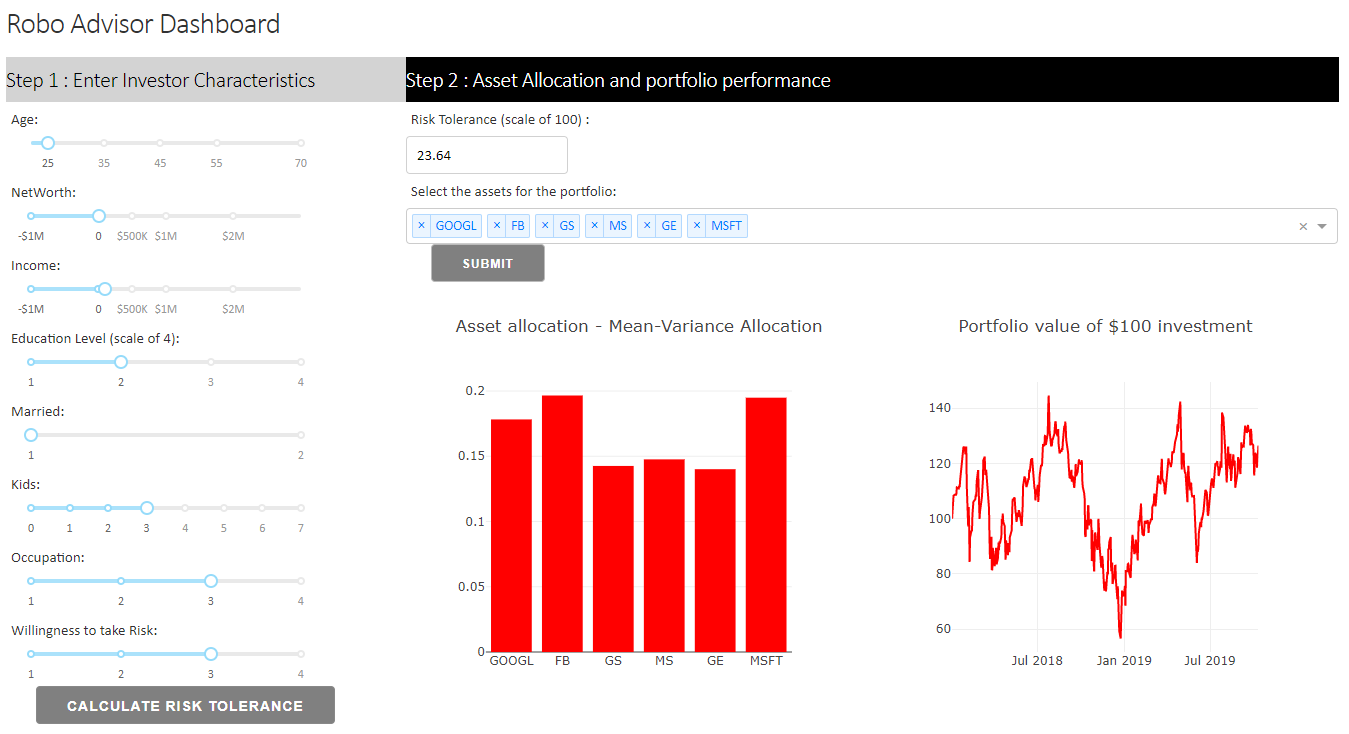